In [ ]:
!pip install anaflow

In [ ]:
import numpy as np
import sympy as sp
import anaflow
import scipy.special as sc
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
from sympy.solvers.solveset import linsolve
from mpmath import *
mp.dps = 15; mp.pretty = True

In [ ]:
#Исходные данные
q_liq = 0.0007 # [m3/c] - дебит скважины
B = 1.4 # [m3/m3] - объемный коэффициент
k = 0.06e-15 # [m2] - изотропная проницаемость ### 0.006 Нужно!
h = 18 # [m] - толщина пласта
f = 0.06 # [] - пористость
c = 1.47*1e-9 # [1/Pa] - сжимаемость флюида
cf = 1 * 1e-9 # [1/Pa] - сжимаемость породы
ct = (c + cf) # [1/Pa] - общая породы
rw = 0.114 # [m] - радиус ствола скважины
r = 0.114 # [m] - радиальная координата и расстояние
mu = 0.38e-3 # [Pa*c] - вязкость ### 0.38 Нужно!
eta = k / (mu * f * ct) # коэф пьезопроводности 
eta_x = (eta ** 2 * 10) ** (1/2) # [] - коэффициент пьезопроводности в x направлении
eta_y = eta_x # [] - коэффициент пьезопроводности в y направлении
eta_z = 0.1 * eta_x # [] - коэффициент пьезопроводности в z направлении
xd = rw / rw
xf = 125 # - [м] - полудлина трещины 
yd = 0
zd = 0
x_wd = 0
y_d = 0
l = rw # - характеристическая длина в системе
y_wd = 0
tetta = 0
pi = 2.1E+7


In [ ]:
def td_2_t(td, eta = eta, l = l):
  return l ** 2 * td / eta

In [ ]:
def t_2_td(t, eta = eta, l = l):
  return  t * eta / l ** 2

In [ ]:
def rd(xd = xd, yd = yd, zd = zd):
  return (xd ** 2 + yd ** 2 + zd ** 2) ** 0.5

In [ ]:
def hd(h = h, k = k, kz = 1 * k, l = l):
  return h * (k / kz) ** 0.5 / l

In [ ]:
def en(u, n, hd = hd()):
  return (u + n ** 2 * np.pi ** 2 / hd** 2)

In [ ]:
def func_vert_grp_well(s, a ,  hd = hd(), x_d = 0, x_wd = x_wd, y_d = y_d, y_wd = y_wd, k = k, kx = k):
  return sc.kn(0, ((x_d - x_wd - a * (k / kx) ** 0.5) ** 2 + (y_d - y_wd) ** 2) ** 0.5 * s ** 0.5) 

In [ ]:
def vert_grp_well(s,  hd = hd(), xf = xf, q_liq = q_liq, B = B, k = k):
  v = np.zeros(len(s))
  m = 0
  for i in s:
    an = np.linspace(-(xf/l), (xf/l), 500)
    v[m] = np.trapz(func_vert_grp_well(i, an), an)
    m += 1

  return  q_liq * mu * B / (4 * np.pi * k * xf * hd * s  ) * v

In [ ]:
def func_vert_grp_well_1(s,rd_s, a = 0 , rd=rw/l,  tetta = tetta):
  return sc.kn(0, (rd ** 2 + rd_s ** 2 - 2 * rd * rd_s * np.cos(tetta-a)) ** 0.5 * s ** 0.5) 

In [ ]:
def func_vert_grp_well_2(s, rd_s, a = 0, rd=rw/l, tetta = tetta):
  return sc.kn(0, (rd ** 2 + rd_s ** 2 - 2 * rd * rd_s * np.cos(tetta-a-np.pi)) ** 0.5 * s ** 0.5) 

In [ ]:
def vert_grp_well_12(s, rd=rw/l, hd = hd(), xf = xf, q_liq = q_liq, mu = mu, B = B, k = k):
  v = np.zeros(len(s))
  m = 0
  for i in s:
    an = np.linspace(0, (xf/l), 600)
    v[m] = np.trapz(func_vert_grp_well_1(i, an), an) + np.trapz(func_vert_grp_well_2(i, an), an)
    m += 1

  return  q_liq * mu * B / (4 * np.pi * k  * hd * xf * s) * v

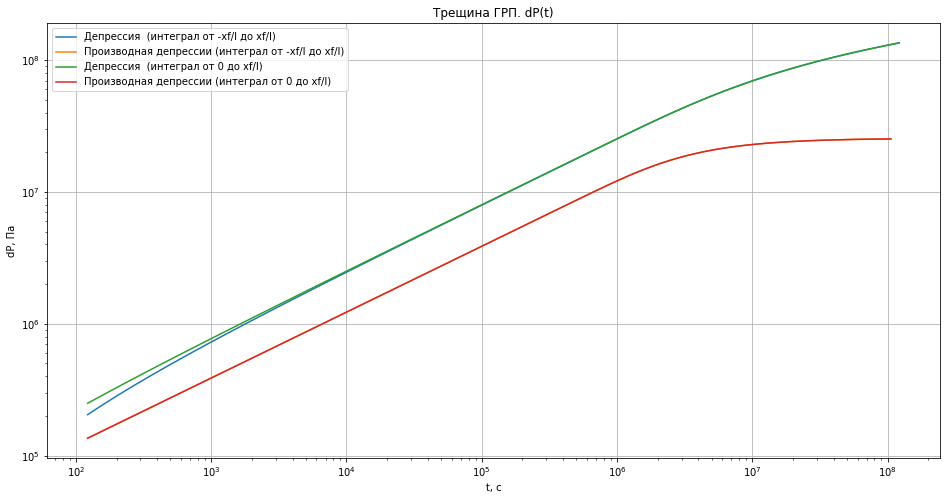

In [ ]:
t = np.logspace(1, 7, 100)
fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)
pd_lps = anaflow.get_lap_inv(vert_grp_well)
pd_lps1 = anaflow.get_lap_inv(vert_grp_well_12)
ax1.plot(td_2_t(t), pd_lps(t), label = 'Депрессия  (интеграл от -xf/l до xf/l) ')
ax1.plot(td_2_t(t)[:-1], np.diff(pd_lps(t))/np.diff(td_2_t(t)) * td_2_t(t)[:-1], label = "Производная депрессии (интеграл от -xf/l до xf/l)")
ax1.plot(td_2_t(t), pd_lps1(t) , label = 'Депрессия  (интеграл от 0 до xf/l) ')
ax1.plot(td_2_t(t)[:-1], np.diff(pd_lps1(t))/np.diff(td_2_t(t)) * td_2_t(t)[:-1], label = "Производная депрессии (интеграл от 0 до xf/l)")
plt.title("Трещина ГРП. dP(t)")
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.xlabel("t, c")
plt.ylabel("dP, Па")
ax1.grid()
ax1.legend()

In [ ]:
def func_vert_grp_well_i_j(s, a, i, j, hd = hd(), k = k, kx = k):
  x = [0, 0, 0, 0, 0, 0, 0, 0, 0]
  y = [0, 0, 0, 0, 0, 0, 0, 0, 0]
  for m in range(9):
    x[m] = (m % 3) * 250/3/l
    y[m] = (m // 3) * 80/l 
  return sc.k0(((x[j] - x[i] - a * (k / kx) ** 0.5) ** 2 + (y[j] - y[i]) ** 2) ** 0.5 * s ** 0.5) 

In [ ]:
def uno(s, xf = 41.66, mu = mu, B = B, l = l, k = k, hd = hd()):
  q, p, q0_0, q1_1, q2_2, q3_3, q4_4, q5_5, q6_6, q7_7, q8_8 = symbols('q, p, q0_0, q1_1, q2_2, q3_3, q4_4, q5_5, q6_6, q7_7, q8_8')
  v = np.zeros(len(s))
  m = 0
  an = np.linspace(-(xf/l), (xf/l), 500)
  koef = mu * B / (4 * np.pi * k * xf * hd) 
  for i in s:
    eq1 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 0), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 0), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 0), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 0), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 0), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 0), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 0), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 0), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 0), an), p) 
    eq2 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 1), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 1), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 1), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 1), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 1), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 1), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 1), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 1), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 1), an), p)
    eq3 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 2), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 2), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 2), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 2), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 2), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 2), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 2), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 2), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 2), an), p)
    eq4 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 3), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 3), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 3), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 3), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 3), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 3), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 3), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 3), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 3), an), p)
    eq5 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 4), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 4), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 4), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 4), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 4), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 4), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 4), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 4), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 4), an), p)
    eq6 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 5), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 5), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 5), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 5), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 5), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 5), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 5), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 5), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 5), an), p)
    eq7 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 6), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 6), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 6), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 6), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 6), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 6), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 6), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 6), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 6), an), p)
    eq8 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 7), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 7), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 7), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 7), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 7), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 7), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 7), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 7), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 7), an), p)
    eq9 = sp.Eq(q0_0 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 0, 8), an) + q1_1 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 1, 8), an) + q2_2 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 2, 8), an) + q3_3 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 3, 8), an) + q4_4 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 4, 8), an) + q5_5 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 5, 8), an) + q6_6 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 6, 8), an) + q7_7 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 7, 8), an) + q8_8 * koef / i * np.trapz(func_vert_grp_well_i_j(i, an, 8, 8), an), p)
    eq10 = sp.Eq(q0_0 + q1_1 + q2_2 + q3_3 + q4_4 + q5_5 + q6_6 + q7_7 + q8_8, q)
    eq11 = sp.Eq(q, 0.00085)
    a = sp.solve([ eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9, eq10, eq11], (p, q0_0, q1_1, q2_2, q3_3, q4_4, q5_5, q6_6, q7_7, q8_8, q ))
    v[m] = a.get(p)
    m += 1
  return  v


In [ ]:
tn = np.linspace(1, 820000, 50)
t = t_2_td(tn)

In [ ]:
pd_lps2 = anaflow.get_lap_inv(uno)
c = pd_lps1(t)
b = td_2_t(t)
a = pd_lps2(t)

In [ ]:
x = [0,1,2,3,4,5,6,7,8,9]
y = [2.1e7, 1.8E+7,1.68E+7,1.58E+7,1.5E+7,1.43E+7,1.36E+7,1.3E+7,1.25E+7,1.21E+7]

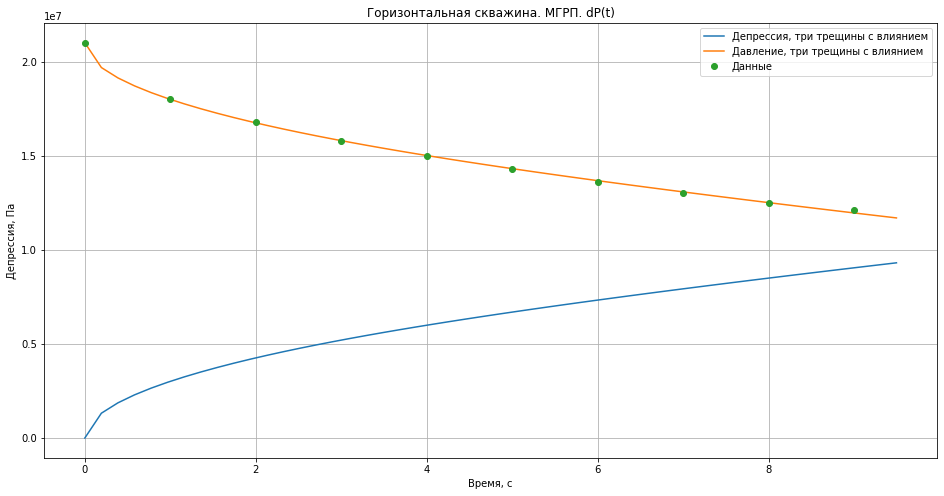

In [ ]:

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)
ax1.plot(tn/86400, a , label = 'Депрессия, три трещины с влиянием')
ax1.plot(tn/86400, pi-a , label = 'Давление, три трещины с влиянием')
ax1.plot(x, y ,'o', label = 'Данные')
plt.title("Горизонтальная скважина. МГРП. dP(t)")
plt.xlabel("Время, c")
plt.ylabel("Депрессия, Па")
ax1.grid()
ax1.legend()

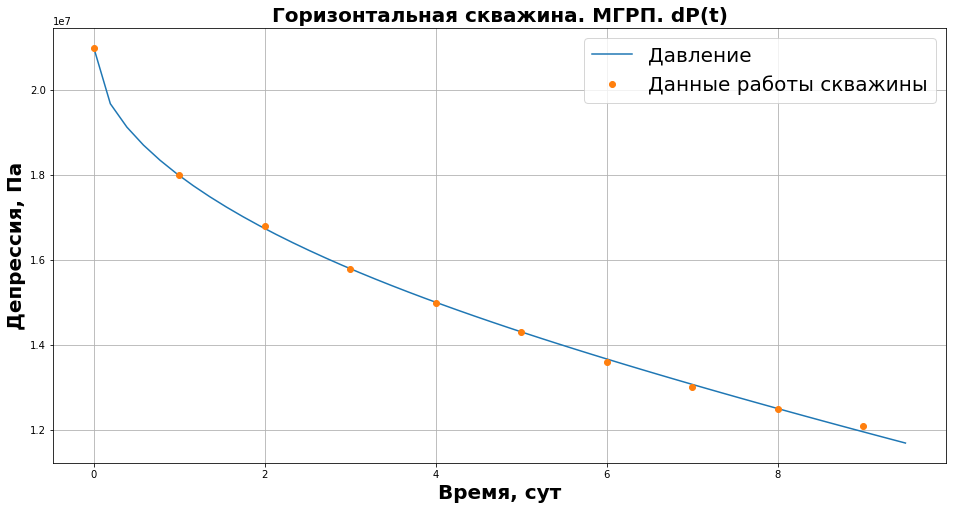

In [ ]:
fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)
ax1.plot(tn/86400, pi-a , label = 'Давление' )
ax1.plot(x, y ,'o', label = 'Данные работы скважины')
plt.title("Горизонтальная скважина. МГРП. dP(t)", fontsize=20, fontweight="bold")
plt.xlabel("Время, cут", fontsize=20, fontweight="bold")
plt.ylabel("Депрессия, Па", fontsize=20, fontweight="bold")

ax1.grid()
ax1.legend( fontsize=20)

In [ ]:
x1 = [0, 1*86400,2*86400,3*86400,4*86400,5*86400,6*86400,7*86400,8*86400,9*86400]
y1 = [pi-2.1E+7,pi-1.8E+7,pi-1.68E+7,pi-1.58E+7,pi-1.5E+7,pi-1.43E+7,pi-1.36E+7,pi-1.3E+7,pi-1.25E+7,pi-1.21E+7]

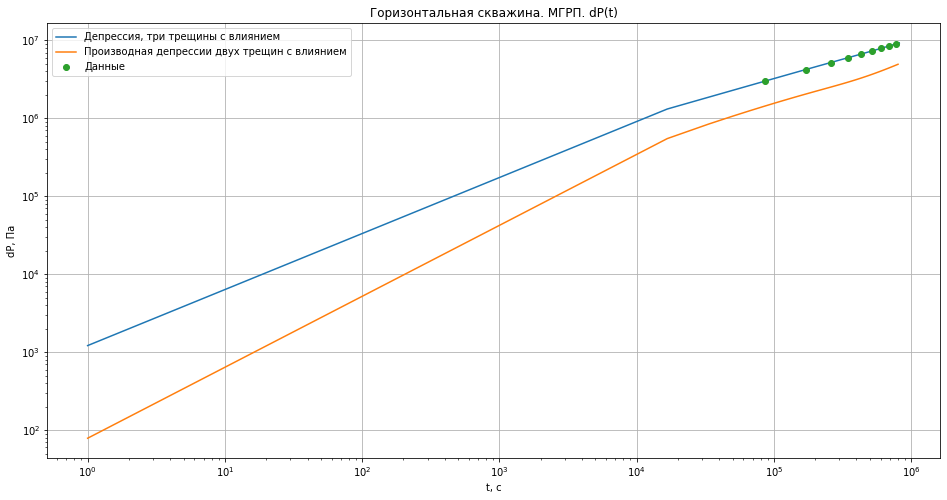

In [ ]:

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)
ax1.plot(tn, a , label = 'Депрессия, три трещины с влиянием')
ax1.plot(tn[:-1], np.diff(a)/np.diff(tn) * tn[:-1], label = "Производная депрессии двух трещин с влиянием")
plt.title("Горизонтальная скважина. МГРП. dP(t)")
ax1.plot(x1, y1 ,'o', label = 'Данные')
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.xlabel("t, c")
plt.ylabel("dP, Па")
ax1.grid()
ax1.legend()